In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, Account, BlockNumber, Records, JoinType
from models.credmark.protocols.dexes.uniswap.univ3_math import tick_to_price, sqrt_price_x_96_to_price, tick_to_sqrt_price_x_96, sqrt_price_x_96_to_tick
from functools import partial

cmf_param = {
    'chain_id': 1,
    'block_number': 18_433_111,  # Remove this line to use the latest block
}

context, _model_loader = create_cmf(cmf_param)

In [2]:
df_weth_usdc = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8", "startBlock": 15_033_111, "interval": 100_000})['results'])

df_weth_usdt = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36", "startBlock": 15_033_111, "interval": 100_000})['results'])

df_weth_dai = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0xC2e9F25Be6257c210d7Adf0D4Cd6E3E881ba25f8", "startBlock": 15_033_111, "interval": 100_000})['results'])

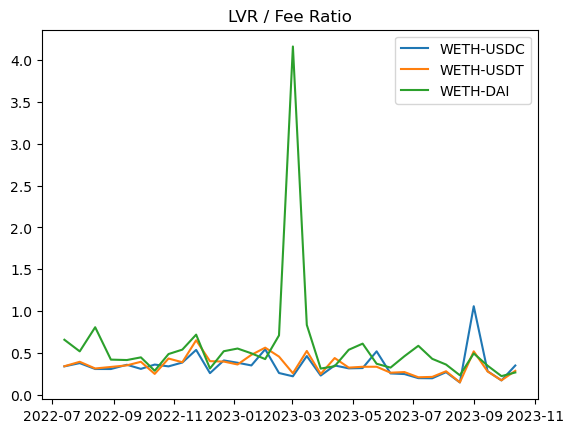

In [3]:
a = df_weth_usdc.loc[:, ['to_timestamp', 'fee_all_in_token1', 'lvr_in_token1']].assign(
    pool='WETH-USDC',
    ratio=lambda r: r.lvr_in_token1 / r.fee_all_in_token1,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

b = df_weth_usdt.loc[:, ['to_timestamp', 'fee_all_in_token0', 'lvr_in_token0']].assign(
    pool='WETH-USDT',
    ratio=lambda r: r.lvr_in_token0 / r.fee_all_in_token0,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

c = df_weth_dai.loc[:, ['to_timestamp', 'fee_all_in_token0', 'lvr_in_token0']].assign(
    pool='WETH-DAI',
    ratio=lambda r: r.lvr_in_token0 / r.fee_all_in_token0,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

plt.plot(a['to_timestamp'], a['ratio'], label='WETH-USDC')
plt.plot(b['to_timestamp'], b['ratio'], label='WETH-USDT')
plt.plot(c['to_timestamp'], c['ratio'], label='WETH-DAI')
plt.legend()
plt.title('LVR / Fee Ratio')
plt.show()

In [4]:
a['ratio'].mean(), b['ratio'].mean(), c['ratio'].mean()

(0.34382460920183033, 0.34959054670325207, 0.5801994498332911)

In [5]:
c[c['ratio'] < 4].ratio.mean()

0.46815916802296725

In [6]:
c[c['ratio'] > 4]

,to_timestamp,fee_all_in_token0,lvr_in_token0,pool,ratio
16,2023-03-01 10:14:35+00:00,114684.482321,477716.888541,WETH-DAI,4.165488


In [7]:
display(a, b, c)

,to_timestamp,fee_all_in_token1,lvr_in_token1,pool,ratio
0,2022-07-13 08:04:00+00:00,3005.906299,1013.665224,WETH-USDC,0.337224
1,2022-07-28 20:23:09+00:00,3291.662467,1237.244290,WETH-USDC,0.375872
2,2022-08-13 11:20:57+00:00,1758.777188,537.437675,WETH-USDC,0.305575
3,2022-08-29 08:36:50+00:00,1728.611721,527.794121,WETH-USDC,0.305328
4,2022-09-14 13:09:44+00:00,2105.160462,749.971846,WETH-USDC,0.356254
5,2022-09-28 16:44:23+00:00,2295.849152,704.982724,WETH-USDC,0.307068
6,2022-10-12 16:06:11+00:00,1227.859418,440.362218,WETH-USDC,0.358642
7,2022-10-26 15:21:47+00:00,1099.630187,370.461739,WETH-USDC,0.336897
8,2022-11-09 14:37:59+00:00,2148.864660,823.187211,WETH-USDC,0.383080
9,2022-11-23 13:51:59+00:00,3068.013407,1639.066091,WETH-USDC,0.534243


,to_timestamp,fee_all_in_token0,lvr_in_token0,pool,ratio
0,2022-07-13 08:04:00+00:00,854.017266,289.186398,WETH-USDT,0.338619
1,2022-07-28 20:23:09+00:00,1183.582058,463.962586,WETH-USDT,0.391999
2,2022-08-13 11:20:57+00:00,605.583619,188.881391,WETH-USDT,0.311900
3,2022-08-29 08:36:50+00:00,613.770907,202.590299,WETH-USDT,0.330075
4,2022-09-14 13:09:44+00:00,658.055231,229.761765,WETH-USDT,0.349153
5,2022-09-28 16:44:23+00:00,613.876651,240.624085,WETH-USDT,0.391975
6,2022-10-12 16:06:11+00:00,230.260756,56.848931,WETH-USDT,0.246889
7,2022-10-26 15:21:47+00:00,257.304471,110.883464,WETH-USDT,0.430943
8,2022-11-09 14:37:59+00:00,786.076986,303.942108,WETH-USDT,0.386657
9,2022-11-23 13:51:59+00:00,1021.997234,663.898043,WETH-USDT,0.649608


,to_timestamp,fee_all_in_token0,lvr_in_token0,pool,ratio
0,2022-07-13 08:04:00+00:00,430750.045623,282412.545861,WETH-DAI,0.655630
1,2022-07-28 20:23:09+00:00,557545.929365,288012.598027,WETH-DAI,0.516572
2,2022-08-13 11:20:57+00:00,292551.378034,235644.496254,WETH-DAI,0.805481
3,2022-08-29 08:36:50+00:00,316952.046021,132429.741691,WETH-DAI,0.417823
4,2022-09-14 13:09:44+00:00,358513.236762,148022.229186,WETH-DAI,0.412878
5,2022-09-28 16:44:23+00:00,332718.966412,148007.159581,WETH-DAI,0.444841
6,2022-10-12 16:06:11+00:00,123498.638230,35140.036099,WETH-DAI,0.284538
7,2022-10-26 15:21:47+00:00,142429.203168,69015.395674,WETH-DAI,0.484559
8,2022-11-09 14:37:59+00:00,414040.744233,222509.578899,WETH-DAI,0.537410
9,2022-11-23 13:51:59+00:00,680562.626137,487934.702283,WETH-DAI,0.716958
